# Generating synthetic observations for latent and observed variables for PBMC data with single-cell variational inference (scVI)
Here we employ scVI to generate synthetic observations for latent and observed variables for the PBMC data. We employ both the original approach, built on ordinary variational autoencoders (VAEs) and the variant with a linear decoder network (LDVAE). 

In [1]:
import sys; print(sys.version)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
sys.executable

'/Users/moritz/.julia/conda/3/bin/python'

In [3]:
import scvi
import scvi.dataset
import scvi.models
import scvi.inference
import torch
import numpy
import pandas as pd

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
"""Modified version of the inference function of scVI to allow for sampling from the prior distribution. 
Modified by Martin Treppner."""
from torch.distributions import Normal, Poisson, kl_divergence as kl
def inference2(self, x, batch_index=None, y=None, n_samples=1, transform_batch=None, sample_prior=False, n_cells=3808):
        """Helper function used in forward pass
        """
        x_ = x
        if self.log_variational:
            x_ = torch.log(1 + x_)

        if sample_prior == True:
            # Sampling
            qz_m, qz_v, z = self.z_encoder(x_, y)
            # Set qz_m and qz_v to zero/one in order to sample from prior distribution
            # qz_m is the output of the mean encoder
            # qz_v is the output of the var encoder
            # z denotes latent variables
            qz_m = torch.zeros(n_cells,qz_m.size(1))
            qz_v = torch.ones(n_cells,qz_v.size(1))
            print(qz_m.shape)
            ql_m, ql_v, library = self.l_encoder(x_)
            # Take mean of library sizes to sample from prior
            mean_libsize = torch.mean(ql_m)

            # Set ql_m and ql_v to zero/one in order to sample from prior distribution
            # ql_m is the output of the mean encoder for library sizes
            # ql_v is the output of the var encoder for library sizes
            # library denotes library sizes
            ql_m = torch.ones(n_cells,ql_m.size(1)) * mean_libsize
            ql_v = torch.ones(n_cells,ql_v.size(1))
            print(ql_v.shape)
            if n_samples > 1:
                qz_m = qz_m.unsqueeze(0).expand((n_samples, n_cells, qz_m.size(1)))
                qz_v = qz_v.unsqueeze(0).expand((n_samples, n_cells, qz_v.size(1)))
                qz_m = torch.zeros(qz_m.size())
                qz_v = torch.ones(qz_v.size())
                z = Normal(qz_m, qz_v.sqrt()).sample()
                # when z is normal, untran_z == z
                #untran_z = Normal(qz_m, qz_v.sqrt()).sample()
                #z = self.z_encoder.z_transformation(untran_z)
                ql_m = ql_m.unsqueeze(0).expand((n_samples, n_cells, ql_m.size(1)))
                ql_v = ql_v.unsqueeze(0).expand((n_samples, n_cells, ql_v.size(1)))
                library = Normal(ql_m, ql_v.sqrt()).sample()
        else:
             # Sampling
             qz_m, qz_v, z = self.z_encoder(x_, y)
             ql_m, ql_v, library = self.l_encoder(x_)

             if n_samples > 1:
                qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
                qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
                z = Normal(qz_m, qz_v.sqrt()).sample()
                ql_m = ql_m.unsqueeze(0).expand((n_samples, ql_m.size(0), ql_m.size(1)))
                ql_v = ql_v.unsqueeze(0).expand((n_samples, ql_v.size(0), ql_v.size(1)))
                library = Normal(ql_m, ql_v.sqrt()).sample()


        if transform_batch is not None:
            dec_batch_index = transform_batch * torch.ones_like(batch_index)
        else:
            dec_batch_index = batch_index

        px_scale, px_r, px_rate, px_dropout = self.decoder(
            self.dispersion, z, library, dec_batch_index, y
        )
        if self.dispersion == "gene-label":
            px_r = F.linear(
                one_hot(y, self.n_labels), self.px_r
            )  # px_r gets transposed - last dimension is nb genes
        elif self.dispersion == "gene-batch":
            px_r = F.linear(one_hot(dec_batch_index, self.n_batch), self.px_r)
        elif self.dispersion == "gene":
            px_r = self.px_r
        px_r = torch.exp(px_r)
        print(px_rate.shape)
        return dict(
            px_scale=px_scale,
            px_r=px_r,
            px_rate=px_rate,
            px_dropout=px_dropout,
            qz_m=qz_m,
            qz_v=qz_v,
            z=z,
            ql_m=ql_m,
            ql_v=ql_v,
            library=library,
        )

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We load the expression data and labels to inspect the structure of the data.

In [6]:
celllabels = pd.read_csv("data/PBMC8k_clust_annotation.csv")

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
x =  pd.read_csv("data/PBMC8k_counts.csv")

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
x

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0  AAACCTGAGCATCATC.1  AAACCTGAGCTAGTGG.1  AAACCTGCACATTAGC.1  \
0          IGLC3                   1                   0                   0   
1          IGLC2                  16                   0                   0   
2         S100A8                   1                   0                   0   
3         S100A9                   2                   1                   1   
4           PPBP                   0                   0                   0   
...          ...                 ...                 ...                 ...   
1995      TMIGD2                   0                   0                   0   
1996  AC006369.2                   0                   0                   0   
1997       AP2A1                   0                   1                   0   
1998        NID1                   0                   0                   0   
1999         ADK                   0                   0                   0   

      AAACCTGCACTGTTAG.1  AAACCTGCATAGTAAG.1  AAACCTGCATGAACCT.1  \
0                      0                   0                   0   
1                      0                   0                   1   
2                     16                  97                   1   
3                     35                 130                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
1995                   0                   0                   0   
1996                   0                   0                   1   
1997                   0                   0                   0   
1998                   2                   0                   0   
1999                   0                   0                   0   

      AAACCTGGTAAGAGGA.1  AAACCTGGTAGAAGGA.1  AAACCTGGTCCAGTGC.1  ...  \
0                      0                   0                   0  ...   
1                      0                   0                   0  ...   
2                      1                  17                   1  ...   
3                      0                  19                   2  ...   
4                      0                   0                   0  ...   
...                  ...                 ...                 ...  ...   
1995                   0                   0                   1  ...   
1996                   0                   0                   0  ...   
1997                   0                   1                   0  ...   
1998                   0                   0                   0  ...   
1999                   0                   0                   1  ...   

      TTTGTCACAGGGATTG.1  TTTGTCAGTAGCAAAT.1  TTTGTCAGTCAGATAA.1  \
0                      0                   0                   0   
1                      0                   0                   0   
2                      1                   1                   0   
3                      0                   0                   0   
4                      0                   0                   0   
...                  ...                 ...                 ...   
1995                   0                   0                   0   
1996                   0                   1                   0   
1997                   1                   0                   0   
1998                   0                   0                   0   
1999                   0                   0                   0   

      TTTGTCAGTCGCGTGT.1  TTTGTCAGTTACCGAT.1  TTTGTCATCATGTCCC.1  \
0                      0                   0                   0   
1                      0                   0                   0   
2                     50                   2                   1   
3                     64                   1                   1   
4                      0                   0                   0   
...                  ...                 ...                 ...   
1995                   0                   0              

In [9]:
celllabels["x"]

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0            B-cells
1       CD4+ T-cells
2       CD4+ T-cells
3          Monocytes
4          Monocytes
            ...     
7475    CD8+ T-cells
7476    CD8+ T-cells
7477       Monocytes
7478    CD8+ T-cells
7479    CD8+ T-cells
Name: x, Length: 7480, dtype: object

Then we load the data for usage in scVI.

In [10]:
data_path = "data/PBMC8k_counts.csv"
n_genes = 200
countmatrix = scvi.dataset.CsvDataset(data_path, 
                                save_path = "", 
                                gene_by_cell = True
)

[2021-05-14 12:40:21,630] INFO - scvi.dataset.csv | Preprocessing dataset


/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2021-05-14 12:40:23,701] INFO - scvi.dataset.csv | Finished preprocessing dataset
[2021-05-14 12:40:23,801] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-05-14 12:40:23,802] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-05-14 12:40:23,996] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-05-14 12:40:24,019] INFO - scvi.dataset.dataset | Downsampled from 7480 to 7480 cells


In [11]:
countmatrix.X.shape

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(7480, 2000)

## Fit VAE

We fit a VAE to the data using some hyper-parameters.

In [12]:
n_epochs = 200
lr = 0.0005
n_latent = 10
n_hidden = 128
n_layers = 2
reconstruction_loss = "nb"
batch_size = 32;
dropout_rate = 0.1;

use_batches = False
use_cuda = True

# Set up LDVAE model
vae = scvi.models.VAE(
    countmatrix.nb_genes, 
    n_latent=n_latent, 
    n_hidden=n_hidden,
    dropout_rate=dropout_rate,
    reconstruction_loss=reconstruction_loss, 
)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
trainer = scvi.inference.UnsupervisedTrainer(vae,
    countmatrix,
    frequency=1,
    n_epochs_kl_warmup=50,
    use_cuda=True)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
trainer.train(n_epochs=n_epochs,lr=lr)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2021-05-14 12:40:24,942] INFO - scvi.inference.inference | KL warmup for 50 epochs
training: 100%|██████████| 200/200 [07:40<00:00,  2.30s/it]


We then extract latent space information to inspect what the model has learned.

In [15]:
# Posterior
full = trainer.create_posterior(trainer.model, trainer.gene_dataset,shuffle=False);
latent, batch_indices, labels = full.get_latent()

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
plotdf = pd.DataFrame(data=latent)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
plotdf

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         1         2         3         4         5         6  \
0     1.797313 -0.435630 -2.041199  0.223376 -0.187706  0.748083  0.593631   
1    -1.073225 -1.577530  0.486880 -2.213644 -0.860702 -0.639472 -0.924428   
2    -0.021275 -0.504456  0.526928  0.410380  0.224386  0.619271 -1.572607   
3    -0.856205 -0.122263 -0.368450 -0.937306  1.265023  0.158897  1.418163   
4    -0.931204 -0.482165 -0.434195  0.931044  0.352408  0.139901  1.469185   
...        ...       ...       ...       ...       ...       ...       ...   
7475 -0.034408 -0.991446  0.185286  0.952658 -0.455482 -0.246033 -1.270193   
7476  0.367218 -0.100250 -0.618987  1.593845 -0.474391 -2.303531 -1.204806   
7477 -0.976238 -0.431852 -0.684262 -0.521715  0.637094 -0.423482  1.375184   
7478 -0.691489 -0.328781  0.122140  0.249735 -1.029026  1.280132 -0.686986   
7479 -0.466436 -0.393113 -1.141183  1.179508 -0.013620  0.835574 -1.255937   

             7         8         9  
0     0.352236  1.275802  0.426000  
1    -0.189798 -0.400398  0.826403  
2    -0.142866  0.224188  0.034806  
3     0.540374  1.103056 -0.610721  
4    -0.623331  1.293536 -1.653023  
...        ...       ...       ...  
7475 -0.643379 -0.183168 -0.350229  
7476  0.143179 -0.082898 -0.517164  
7477  0.665897  0.937292 -1.269262  
7478 -1.241416 -1.450152 -0.833346  
7479 -0.325495 -0.303971  0.195098  

[7480 rows x 10 columns]

In [18]:
plotdf['celltype'] = celllabels["x"]

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distribu

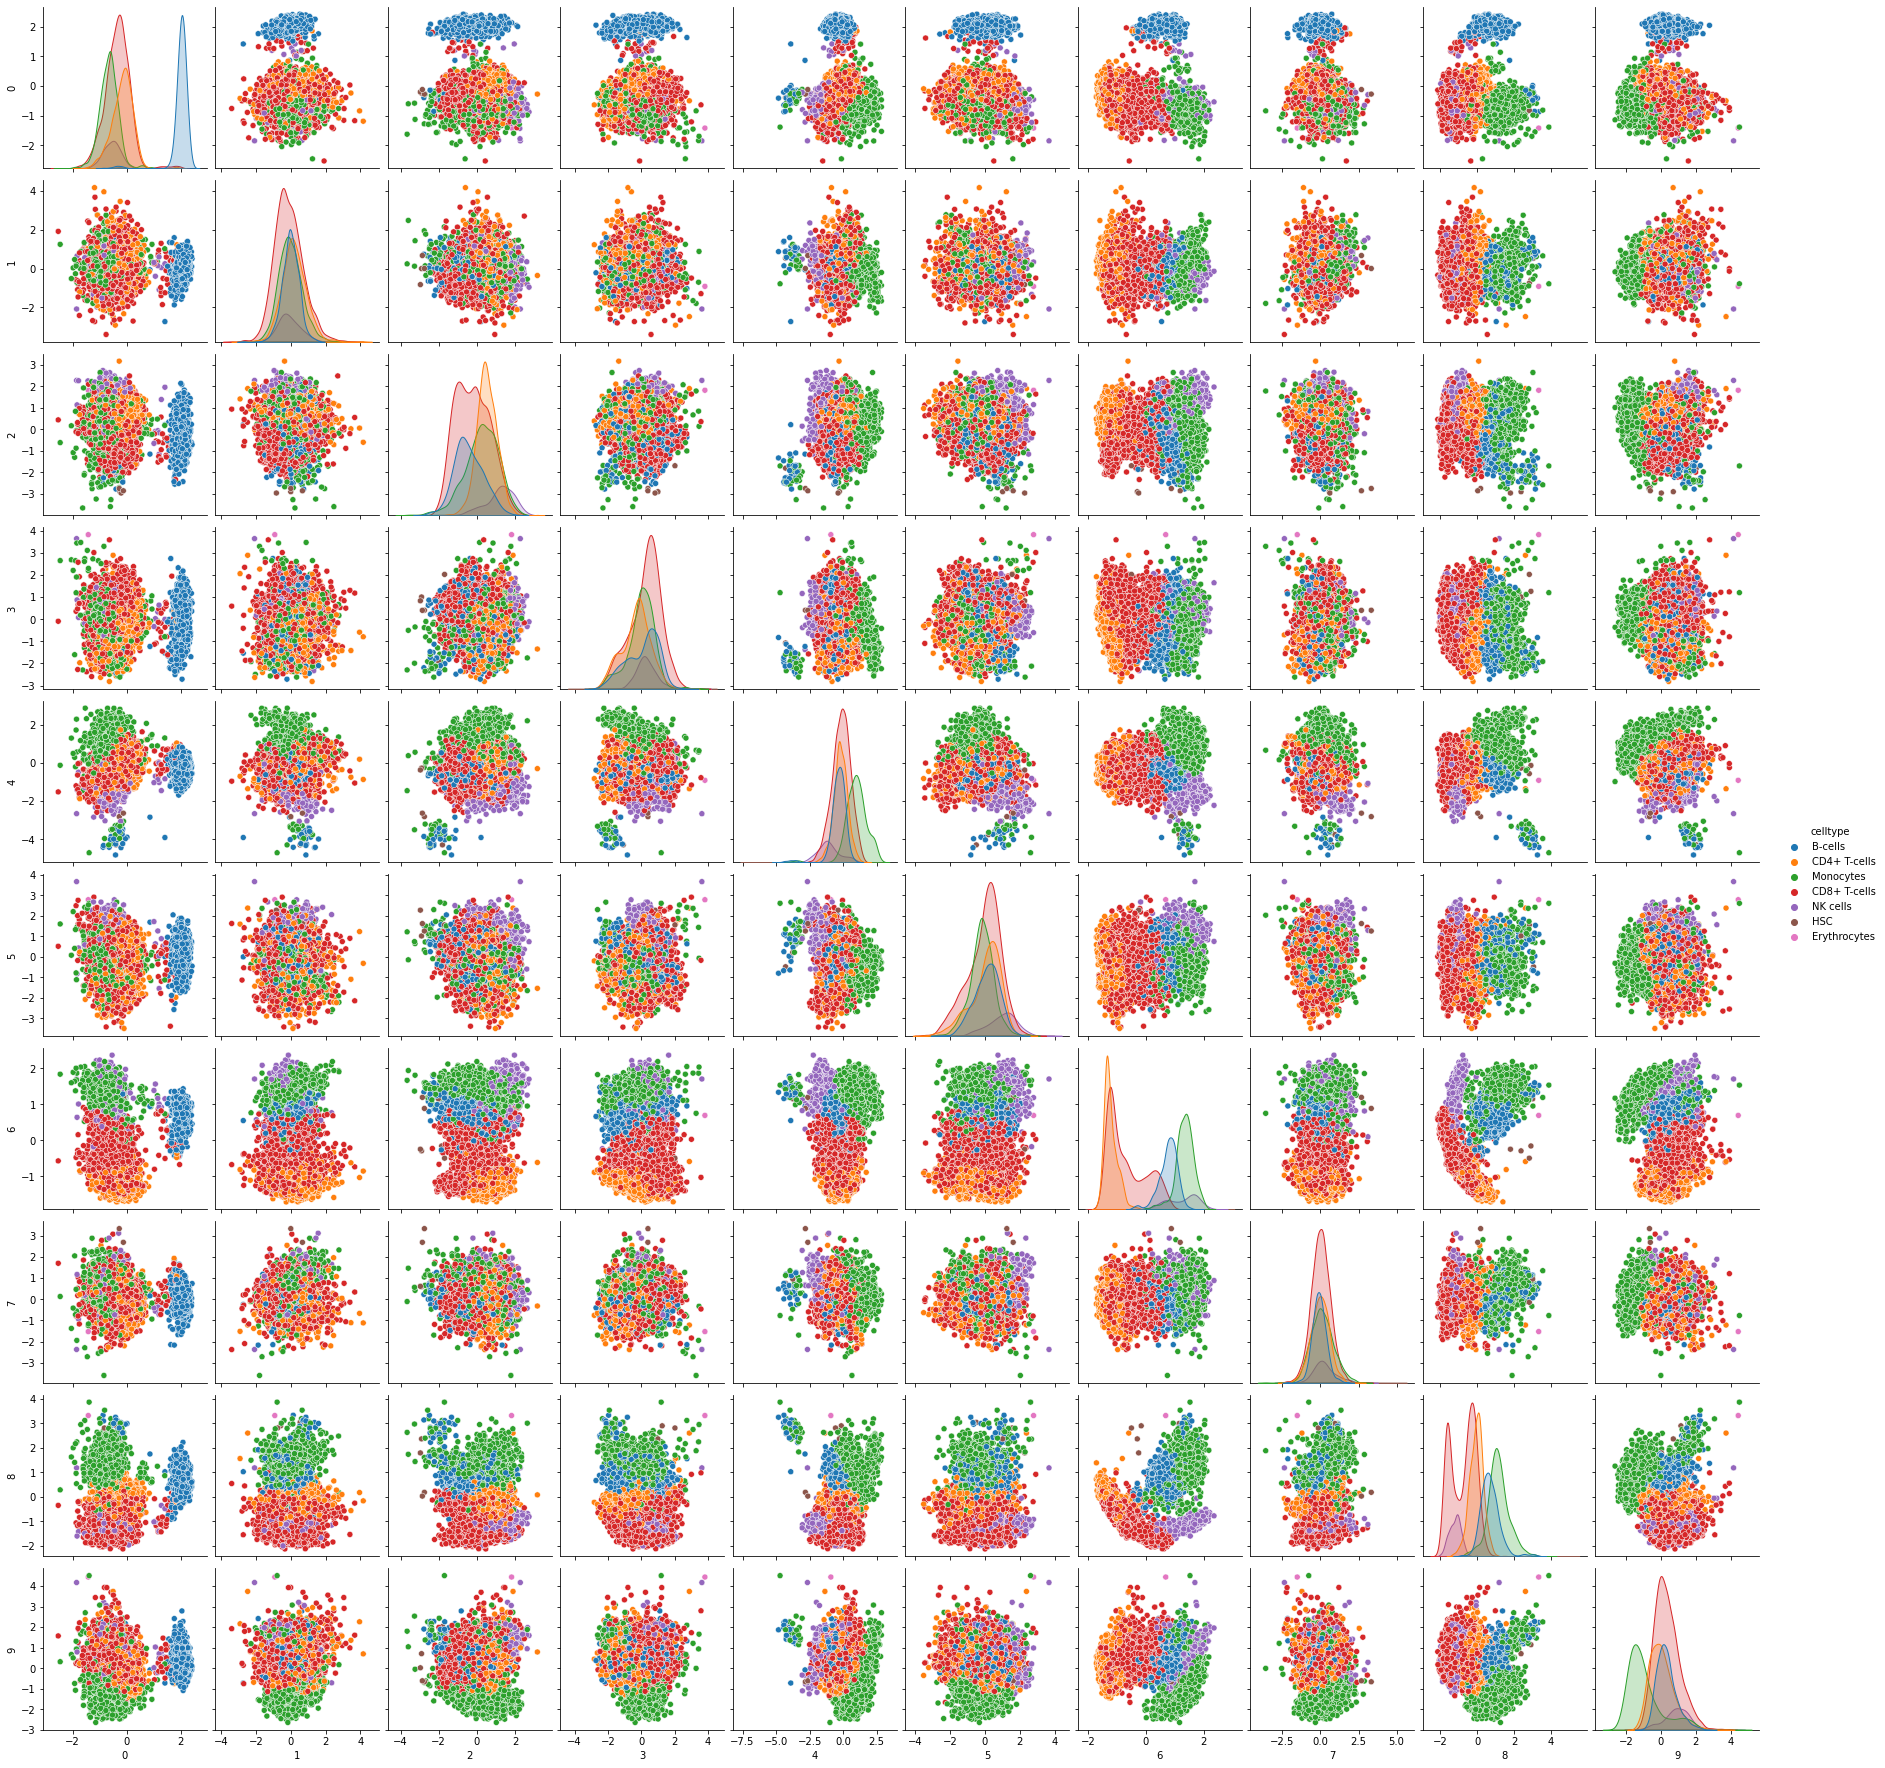

In [19]:
sns.pairplot(plotdf, hue="celltype")

We then draw samples for the latent and observed variables. Here we draw from the posterior distribution, meaning the distribution of latent variables, conditional on the observations, but we could also draw from the prior distribution.

In [20]:
ncells =1000
posteriorsample = inference2(vae,torch.Tensor(countmatrix.X),n_samples=1,sample_prior=False,n_cells=ncells)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([7480, 2000])


In [21]:
zhat = posteriorsample["z"].cpu().detach().numpy()
xhat = posteriorsample["px_rate"].cpu().detach().numpy()

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We save the drawn samples for latent and observed variables for further investigation with log-linera models.

In [22]:
numpy.savetxt("data/xhat_2000_vae_posterior.csv",xhat , delimiter=",")
numpy.savetxt("data/zhat_2000_vae_posterior.csv",zhat , delimiter=",")

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Fit LDVAE
Here the same as shown for the VAE above is repeated with the LDVAE, which lacks hidden layers in the decoder network for improved interpretability of the latent variables. 

In [24]:
n_epochs = 200
lr = 0.0005
n_latent = 10
n_hidden = 128
n_layers = 2
reconstruction_loss = "nb"
batch_size = 32;
dropout_rate = 0.1;

use_batches = False
use_cuda = True

# Set up LDVAE model
ldvae = scvi.models.LDVAE(
    countmatrix.nb_genes, 
    n_latent=n_latent, 
    n_hidden=n_hidden,
    dropout_rate=dropout_rate,
    reconstruction_loss=reconstruction_loss, 
)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
trainer = scvi.inference.UnsupervisedTrainer(ldvae,
    countmatrix,
    frequency=1,
    n_epochs_kl_warmup=50,
    use_cuda=True)

trainer.train(n_epochs=n_epochs,lr=lr)

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2021-05-14 12:48:57,720] INFO - scvi.inference.inference | KL warmup for 50 epochs
training: 100%|██████████| 200/200 [07:37<00:00,  2.29s/it]


/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/seaborn/distribu

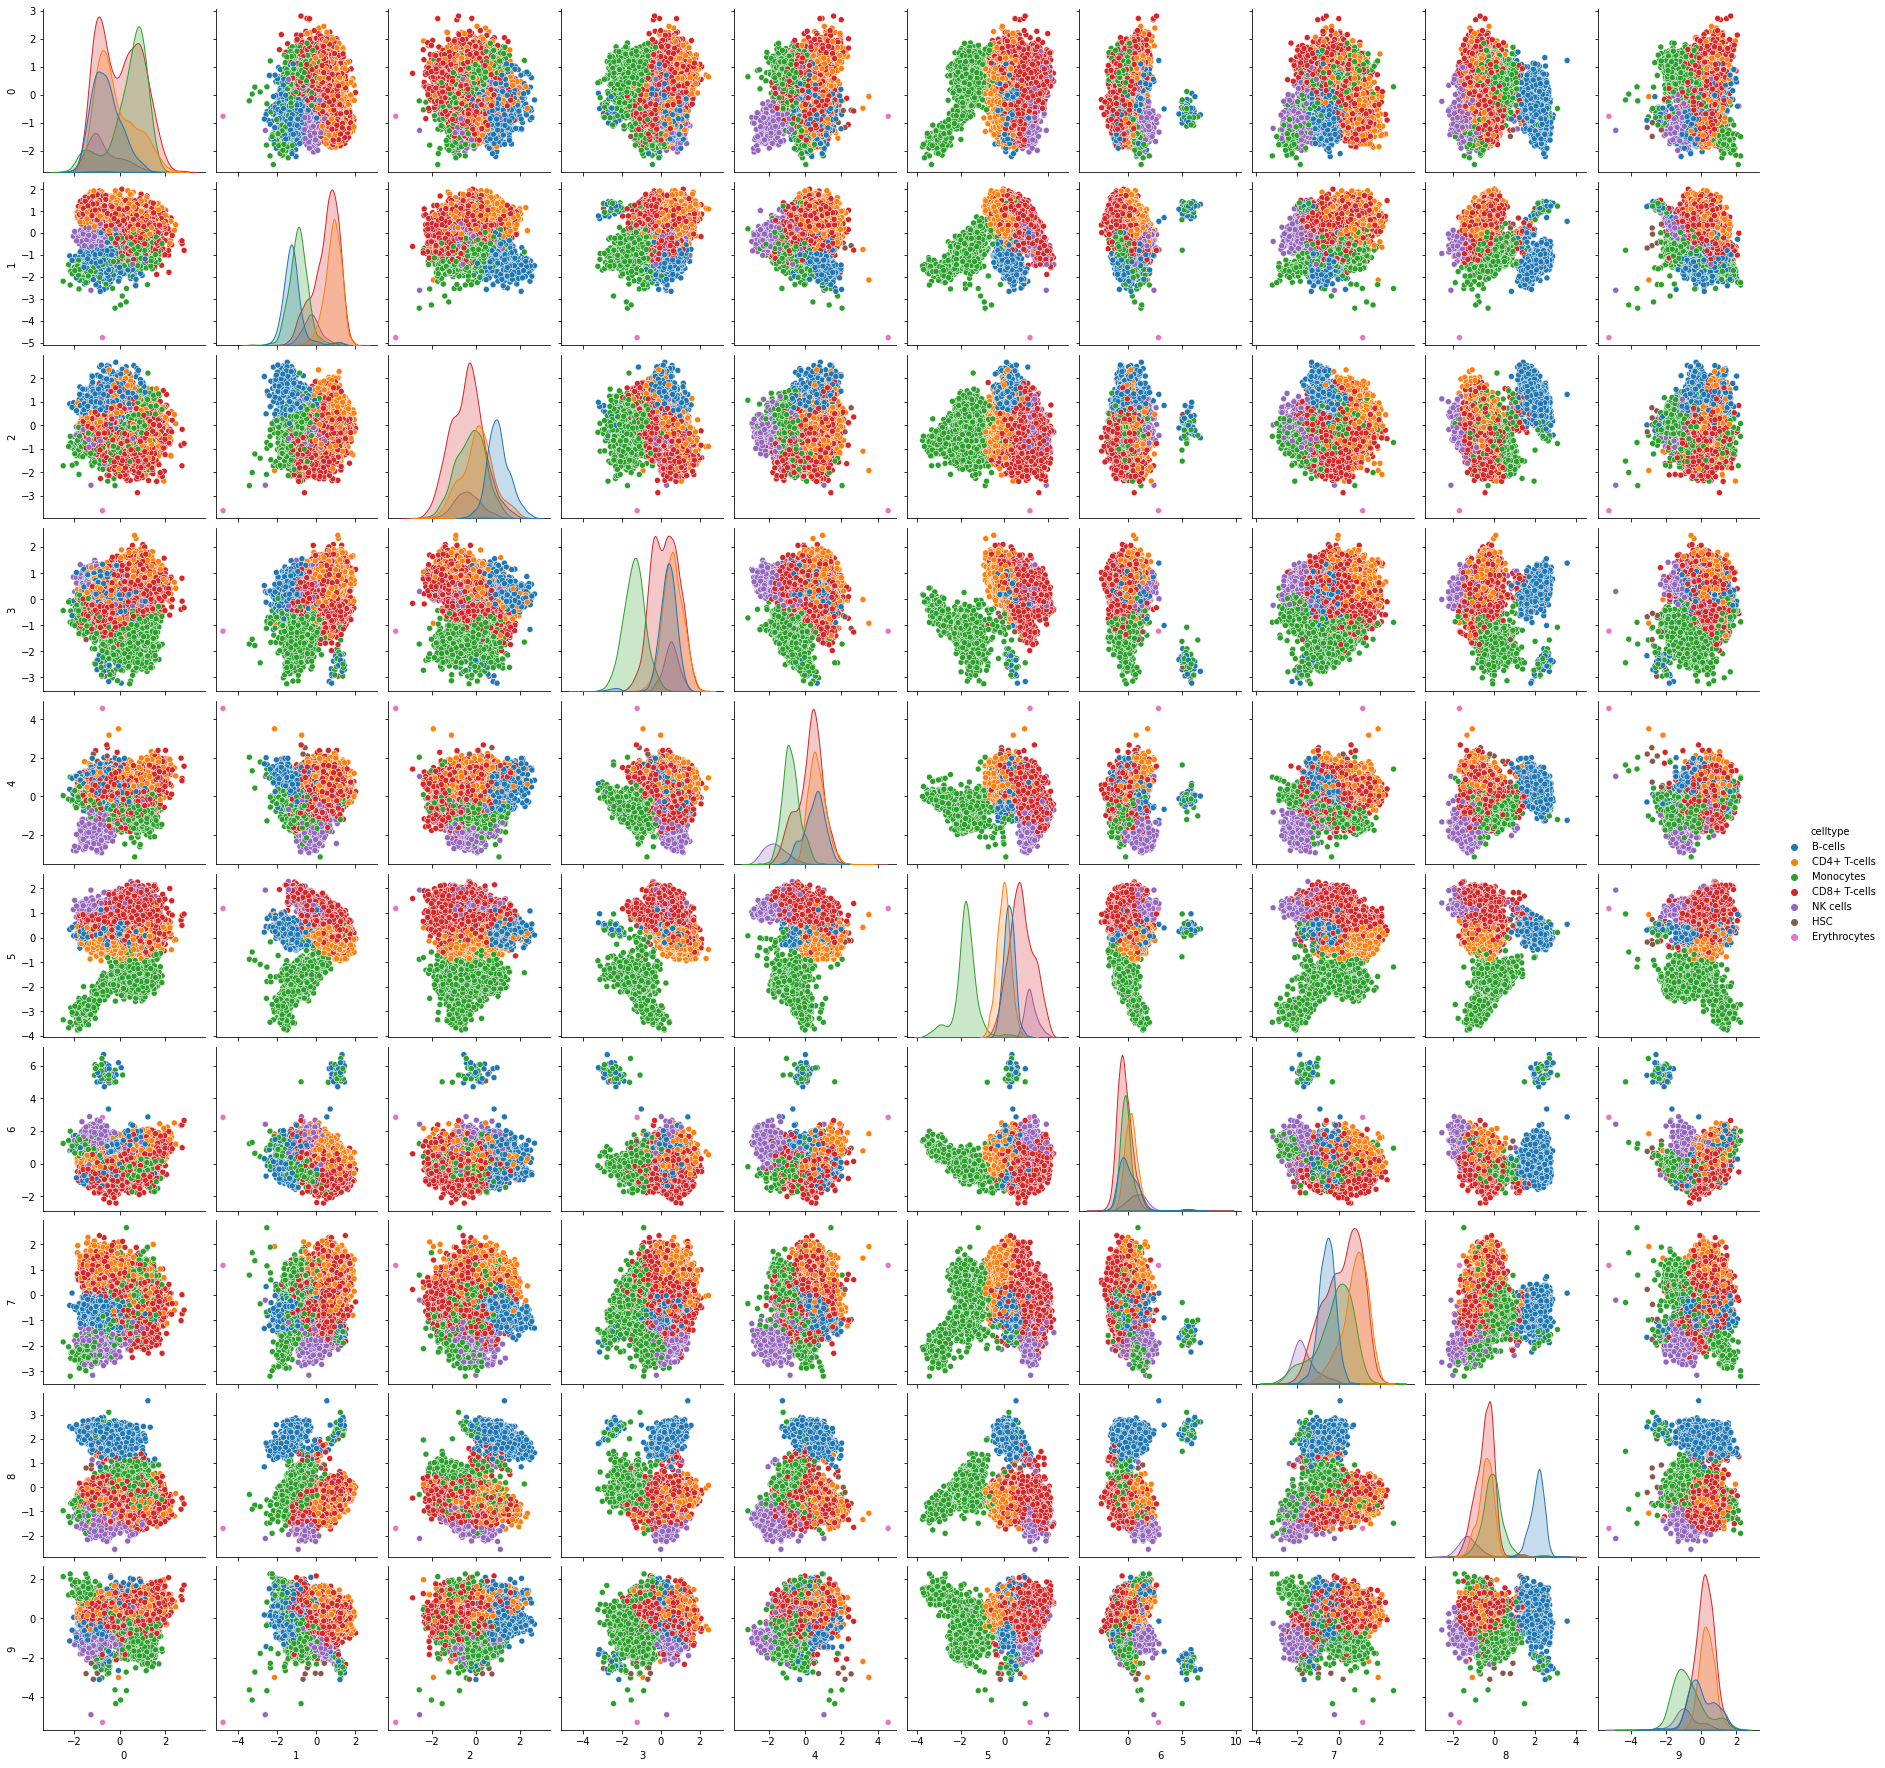

In [26]:
# Posterior
full = trainer.create_posterior(trainer.model, trainer.gene_dataset,shuffle=False);
latent, batch_indices, labels = full.get_latent()

plotdf = pd.DataFrame(data=latent)

plotdf["celltype"] = celllabels["x"]

sns.pairplot(plotdf, hue="celltype")

In [27]:
ncells =1000
priorsample = inference2(ldvae,torch.Tensor(countmatrix.X),n_samples=1,sample_prior=False,n_cells=ncells)

zhat = priorsample["z"].cpu().detach().numpy()
xhat = priorsample["px_rate"].cpu().detach().numpy()

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([7480, 2000])


In [28]:
numpy.savetxt("data/xhat_2000_ldvae_posterior.csv",xhat , delimiter=",")
numpy.savetxt("data/zhat_2000_ldvae_posterior.csv",zhat , delimiter=",")

/Users/moritz/.julia/conda/3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
